In [98]:
from pyomo.environ import (
    ConcreteModel,
    Objective,
    Expression,
    value,
    Var,
    Param,
    Constraint,
    Set,
    Var,
    Block,
    SolverFactory,
    TransformationFactory,
    assert_optimal_termination,
    check_optimal_termination,
    log,
    log10,
    units as pyunits,
)

from pyomo.network import Port
from idaes.core import FlowsheetBlock
from idaes.core.solvers.get_solver import get_solver

from idaes.core.util.model_statistics import *
from idaes.core.util.scaling import *

from idaes.core import UnitModelCostingBlock

from watertap.core.zero_order_costing import ZeroOrderCosting, _get_tech_parameters
from watertap.core.util.infeasible import *
from watertap.costing import WaterTAPCosting

import json
from os.path import join, dirname
from math import floor, ceil

import pytest

from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from IPython.display import clear_output
from copy import deepcopy
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock
from watertap.property_models.water_prop_pack import WaterParameterBlock
from watertap_contrib.seto.costing import SETOZeroOrderCosting, SETOWaterTAPCosting

# from watertap_contrib.seto.solar_models.zero_order import PhotovoltaicZO
# from watertap_contrib.seto.energy import solar_energy
# from watertap_contrib.seto.core import SETODatabase, PySAMWaterTAP
from watertap_contrib.seto.unit_models import ChemicalSoftening0D
from watertap_contrib.seto.property_models.chemical_softening_prop_pack import (
    ChemSofteningParameterBlock,
)

# from watertap_contrib.seto.costing.solar import photovoltaic

solver = get_solver()

In [99]:
def get_ion_config(ions):
    #neutral_solutes = ["TSS", "TDS", "TOC", "NH3", "SiO2"]
    if not isinstance(ions, list):
        ions = [ions]
    #ions = ions + neutral_solutes

    mw_data = {
        "Na_+": 23e-3,
        "Ca_2+": 40e-3,
        "Cl_-": 35e-3,
        "Mg_2+": 24e-3,
        "SO4_2-": 96e-3,
        "NH3": 17.03e-3,
        "SiO2": 60.08e-3,
        "HCO3_-": 61.02e-3,
        "Alkalinity_2-": 31.01736e-3,
        "CO3_2-": 60.01e-3,
        "CO2": 44e-3,
    }
    charge_data = {
        "Na_+": 1,
        "Ca_2+": 2,
        "Cl_-": -1,
        "Mg_2+": 2,
        "SO4_2-": -2,
        "HCO3_-": -1,
        "CO3_2-": -2,
        "Alkalinity_2-": -2,
        "SiO2": 0,
    }
    ion_config = {
        "solute_list": [],
        "mw_data": {"H2O": 18e-3},
        "charge": {},
    }

    for ion in ions:
        ion_config["solute_list"].append(ion)

        if ion in charge_data.keys():
            ion_config["charge"][ion] = charge_data[ion]
        #else: 
        #    ion_config["charge"][ion] = 0   
        if ion in mw_data.keys():
            ion_config["mw_data"][ion] = mw_data[ion]
        #else:   
        #    ion_config["mw_data"][ion] = 0
    return ion_config


charged_comp = ["Ca_2+", "Mg_2+", "HCO3_-"]
get_ion_config(charged_comp)

{'solute_list': ['Ca_2+', 'Mg_2+', 'HCO3_-'],
 'mw_data': {'H2O': 0.018, 'Ca_2+': 0.04, 'Mg_2+': 0.024, 'HCO3_-': 0.06102},
 'charge': {'Ca_2+': 2, 'Mg_2+': 2, 'HCO3_-': -1}}

In [100]:
component_list = ["Ca_2+", "Mg_2+", "SiO2"]
input_config_dict = get_ion_config(component_list)
input_config_dict

{'solute_list': ['Ca_2+', 'Mg_2+', 'SiO2'],
 'mw_data': {'H2O': 0.018, 'Ca_2+': 0.04, 'Mg_2+': 0.024, 'SiO2': 0.06008},
 'charge': {'Ca_2+': 2, 'Mg_2+': 2, 'SiO2': 1}}

In [101]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = ChemSofteningParameterBlock(**input_config_dict)


In [49]:
charged_comp = ["Ca_2+", "Mg_2+", "SiO2"]
neutral_solutes = ["TSS", "TDS", "TOC", "NH3", "SiO2"]
ion_config_dict = get_ion_config(charged_comp)
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = ChemSofteningParameterBlock(**ion_config_dict)
m.fs.soft = soft = ChemicalSoftening0D(
    property_package=m.fs.properties, silica_removal=True
)
soft.retention_time_mixer.fix()
soft.retention_time_floc.fix()
soft.retention_time_sed.fix()
soft.retention_time_recarb.fix()
ca_in = 0.075 * pyunits.kg / pyunits.m**3  # g/L = kg/m3
mg_in = 0.0061 * pyunits.kg / pyunits.m**3  # g/L = kg/m3
alk_in = 0.195 * pyunits.kg / pyunits.m**3  # g/L = kg/m3 as CaCO3
co2_in = 0.072 * pyunits.kg / pyunits.m**3  # g/L = kg/m3
q_in = 50000 * pyunits.m**3 / pyunits.day  # m3/d
rho = 1000 * pyunits.kg / pyunits.m**3
pH_in = 7
temp_in = 293.15  # K
prop_in = m.fs.soft.properties_in[0]
prop_out = m.fs.soft.properties_out[0]
prop_waste = m.fs.soft.properties_waste[0]
if value(ca_in * 2.5) >= value(alk_in):
    prop_in.carbonate_hardness_comp["Ca_2+"].fix(alk_in)
    prop_in.carbonate_hardness_comp["Mg_2+"].fix(0)
    prop_in.non_carbonate_hardness_comp["Ca_2+"].fix(((ca_in * 2.5) - alk_in))
    prop_in.non_carbonate_hardness_comp["Mg_2+"].fix(mg_in * 4.10)
else:
    total_hardness = (ca_in * 2.5) + (mg_in * 4.10)
    prop_in.carbonate_hardness_comp["Ca_2+"].fix(ca_in * 2.5)
    prop_in.carbonate_hardness_comp["Mg_2+"].fix((alk_in - ca_in * 2.5))
    prop_in.non_carbonate_hardness_comp["Ca_2+"].fix(0)
    prop_in.non_carbonate_hardness_comp["Mg_2+"].fix(total_hardness - alk_in)
ca_mass_flow = pyunits.convert((ca_in * q_in), to_units=pyunits.kg / pyunits.s)()
mg_mass_flow = pyunits.convert((mg_in * q_in), to_units=pyunits.kg / pyunits.s)()
co2_mass_flow = pyunits.convert((co2_in * q_in), to_units=pyunits.kg / pyunits.s)()
h2o_mass_flow = pyunits.convert((rho * q_in), to_units=pyunits.kg / pyunits.s)()
# alk_mol_flow = pyunits.convert((alk_in * q_in) / m.fs.properties.mw_comp["Alkalinity_2-"], to_units=pyunits.mol/pyunits.s)()
ca_mass_flow, h2o_mass_flow
m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"].fix(ca_mass_flow)
set_scaling_factor(m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "Ca_2+"], 100)
m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "Mg_2+"].fix(mg_mass_flow)
set_scaling_factor(m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "Mg_2+"], 100)
# m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "CO3_2-"].fix(co2_mass_flow)
# set_scaling_factor(m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "CO3_2-"], 100)
m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "H2O"].fix(h2o_mass_flow)
set_scaling_factor(m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "H2O"], 1e-2)
m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "SiO2"].fix(30)
# m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "TDS"].fix(0.5)
# m.fs.soft.properties_in[0].flow_mass_phase_comp["Liq", "TSS"].fix(0.05)
# m.fs.soft.properties_in[0].conc_mass_phase_comp["Liq", "SiO2"].fix(0.15)
m.fs.soft.properties_in[0].temperature.fix(temp_in)
m.fs.soft.properties_in[0].alkalinity.fix(0.195)
# soft.properties_out[0].calculate_state()
# soft.properties_out[0].conc_mass_phase_comp['Liq', 'Ca_2+'].fix(0.03)
# soft.properties_out[0].conc_mass_phase_comp['Liq', 'Mg_2+'].fix(0.02)
# m.fs.soft.properties_in[0].flow_mol_phase_comp["Liq", "Alkalinity_2-"].fix(alk_mol_flow)
m.fs.soft.properties_in[0].conc_mass_phase_comp
# m.fs.soft.properties_in[0].conc_mass_caco3_comp
m.fs.soft.properties_in[0].flow_vol_phase
# m.fs.soft.properties_in[0].carbonate_hardness_comp
# m.fs.soft.properties_in[0].non_carbonate_hardness_comp
m.fs.soft.properties_in[0].total_hardness
# set_scaling_factor(m.fs.soft.properties_in[0].non_carbonate_hardness_comp, 1e8)
# calculate_scaling_factors(m)


m.fs.soft.properties_out[0].pH.fix(11.34)
m.fs.soft.initialize()
# m.fs.soft.excess_lime.fix(170)
solver = get_solver()
results = solver.solve(m)
# # m.fs.soft.display()
print(f"DOF = {degrees_of_freedom(m)}")
print(results.solver.termination_condition.swapcase())
print_infeasible_constraints(m)
# lime_flow = m.fs.soft.excess_lime * prop_in.flow_vol_phase["Liq"]
# lime_flow = pyunits.convert(lime_flow, to_units=pyunits.kg/pyunits.day)()
# print(lime_flow)
soft.mg_add.display()

ERROR: Rule failed for Param 'fs.properties.mw_comp' with index SiO2:
    KeyError: "Index 'SiO2' is not valid for indexed component
    'fs.properties.mw_comp'"
ERROR: Constructing component 'fs.properties.mw_comp' from data=None failed:
    KeyError: "Index 'SiO2' is not valid for indexed component
    'fs.properties.mw_comp'"
2023-02-08 16:57:13 [ERROR] idaes.core.base.process_block: Failure in build: fs.properties
Traceback (most recent call last):
  File "c:\Users\mhardika\miniconda3\envs\watertap-seto\lib\site-packages\idaes\core\base\process_block.py", line 39, in _rule_default
    b.build()
  File "c:\users\mhardika\documents\watertap_seto\watertap-seto\src\watertap_contrib\seto\property_models\chemical_softening_prop_pack.py", line 325, in build
    # self.mw_CaCO3 = Param(initialize=100e-3, units=pyunits.kg/pyunits.mol)
  File "c:\Users\mhardika\miniconda3\envs\watertap-seto\lib\site-packages\pyomo\core\base\block.py", line 649, in __setattr__
    self.add_component(name, val

KeyError: "Index 'SiO2' is not valid for indexed component 'fs.properties.mw_comp'"

In [9]:
prop_in.component_list.display()

component_list : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    4 : {'H2O', 'Ca_2+', 'Mg_2+', 'SiO2'}


In [11]:
prop_in.flow_mass_phase_comp.display()
prop_in.mass_frac_phase_comp.display()
prop_in.conc_mass_phase_comp.display()
prop_in.flow_vol_phase.display()

flow_mass_phase_comp : Mass flow rate
    Size=4, Index=fs.soft.properties_in[0.0].flow_mass_phase_comp_index, Units=kg/s
    Key              : Lower : Value                 : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 :  0.043402777777777776 :  None :  True :  True : NonNegativeReals
      ('Liq', 'H2O') :     0 :     578.7037037037037 :  None :  True :  True : NonNegativeReals
    ('Liq', 'Mg_2+') :     0 : 0.0035300925925925925 :  None :  True :  True : NonNegativeReals
     ('Liq', 'SiO2') :     0 :                    30 :  None :  True :  True : NonNegativeReals
mass_frac_phase_comp : Mass fraction
    Size=4, Index=fs.soft.properties_in[0.0].mass_frac_phase_comp_index
    Key              : Lower : Value                  : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 :  7.129812302462607e-05 : 1.001 : False : False :  Reals
      ('Liq', 'H2O') :     0 :     0.9506416403283477 : 1.001 : False : False :  Reals
    ('Liq', 'Mg_2+') :     0 :   4.823

In [7]:
prop_waste.flow_mass_phase_comp.display()
prop_waste.mass_frac_phase_comp.display()
prop_waste.conc_mass_phase_comp.display()

flow_mass_phase_comp : Mass flow rate
    Size=4, Index=fs.soft.properties_waste[0.0].flow_mass_phase_comp_index, Units=kg/s
    Key              : Lower : Value                 : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 :  0.036491580215276286 :  None : False : False : NonNegativeReals
      ('Liq', 'H2O') :     0 :     5.195581067986164 :  None : False : False : NonNegativeReals
    ('Liq', 'Mg_2+') :     0 : 1.443238103315495e-09 :  None : False : False : NonNegativeReals
     ('Liq', 'SiO2') :     0 :    0.5854337160961516 :  None : False : False : NonNegativeReals
mass_frac_phase_comp : Mass fraction
    Size=4, Index=fs.soft.properties_waste[0.0].mass_frac_phase_comp_index
    Key              : Lower : Value : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 :   0.5 : 1.001 : False : False :  Reals
      ('Liq', 'H2O') :     0 :   0.5 : 1.001 : False : False :  Reals
    ('Liq', 'Mg_2+') :     0 :   0.5 : 1.001 : False : False :  Reals
     ('Liq', 

In [6]:
pin = soft.properties_in[0]
pout = soft.properties_out[0]
pw = soft.properties_waste[0]
pw.conc_mass_phase_comp[...]
for c in soft.config.property_package.component_list:
    print(c)
    if c == "H2O":
        print(
            f"\tFLOW VOL IN = {round(pin.flow_vol(), 3)} m3/s = {round(pyunits.convert(pin.flow_vol, to_units=pyunits.Mgallons/pyunits.d)(), 4)} MGD"
        )
        print(
            f"\tFLOW VOL OUT = {round(pout.flow_vol(), 3)} m3/s = {round(pyunits.convert(pout.flow_vol, to_units=pyunits.Mgallons/pyunits.d)(), 4)} MGD"
        )
        print(
            f"\tFLOW VOL WASTE = {round(pw.flow_vol(), 3)} m3/s = {round(pyunits.convert(pw.flow_vol, to_units=pyunits.Mgallons/pyunits.d)(), 4)} MGD"
        )
        continue
    print(
        f'\tCONC. IN = {round(pyunits.convert(pin.conc_mass_phase_comp["Liq", c], to_units=pyunits.mg/pyunits.liter)(), 4)} mg/L'
    )
    print(
        f'\tCONC. OUT = {round(pyunits.convert(pout.conc_mass_phase_comp["Liq", c], to_units=pyunits.mg/pyunits.liter)(), 4)} mg/L'
    )
    print(
        f'\tCONC. WASTE = {round(pyunits.convert(pw.conc_mass_phase_comp["Liq", c], to_units=pyunits.mg/pyunits.liter)(), 4)} mg/L'
    )
    print(f'\tMASS FLOW IN = {round(pin.flow_mass_phase_comp["Liq", c](), 4)} kg/s')
    print(f'\tMASS FLOW OUT = {round(pout.flow_mass_phase_comp["Liq", c](), 4)} kg/s')
    print(f'\tMASS FLOW WASTE = {round(pw.flow_mass_phase_comp["Liq", c](), 4)} kg/s')

    print(f"")

H2O
	FLOW VOL IN = 0.609 m3/s = 13.8944 MGD
	FLOW VOL OUT = 0.603 m3/s = 13.7555 MGD
	FLOW VOL WASTE = 0.006 m3/s = 0.1389 MGD
Ca_2+
	CONC. IN = 71.2981 mg/L
	CONC. OUT = 12.0 mg/L
	CONC. WASTE = 10000.0 mg/L
	MASS FLOW IN = 0.0434 kg/s
	MASS FLOW OUT = 0.0072 kg/s
	MASS FLOW WASTE = 0.0362 kg/s

Mg_2+
	CONC. IN = 5.7989 mg/L
	CONC. OUT = 5.7989 mg/L
	CONC. WASTE = 10000.0 mg/L
	MASS FLOW IN = 0.0035 kg/s
	MASS FLOW OUT = 0.0035 kg/s
	MASS FLOW WASTE = 0.0 kg/s

SiO2
	CONC. IN = 0.0 mg/L
	CONC. OUT = 45764.7822 mg/L
	CONC. WASTE = 10000.0 mg/L
	MASS FLOW IN = 30 kg/s
	MASS FLOW OUT = 27.5807 kg/s
	MASS FLOW WASTE = 2.4193 kg/s



In [1]:
m.fs.soft.properties_in[0].params.mw_comp.display()

NameError: name 'm' is not defined

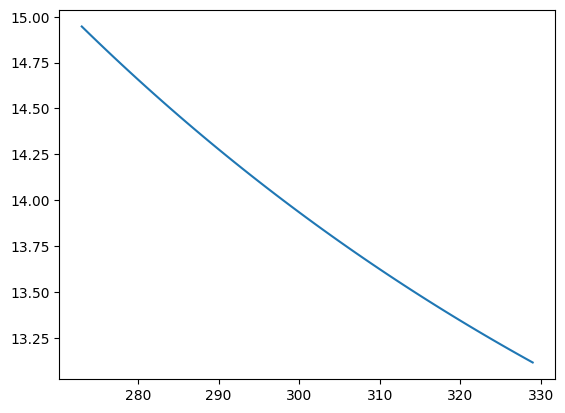

In [ ]:
def pkw(t):
    return 4470.99 / t + 0.017060 * t - 6.0875


ts = np.arange(273, 330)
plt.plot(ts, pkw(ts))

In [ ]:
pyunits.convert((rho * q_in), to_units=pyunits.kg / pyunits.s)()

578.7037037037037

In [ ]:
m.fs.soft.properties_in[0].non_carbonate_hardness_comp.display()

non_carbonate_hardness_comp : Non-carbonate hardness in CaCO3 equivalents
    Size=2, Index=fs.properties.hardness_set, Units=kg/m**3
    Key   : Lower : Value                 : Upper : Fixed : Stale : Domain
    Ca_2+ :     0 : 6.164766491848106e-09 :  None : False : False :  Reals
    Mg_2+ :     0 :  0.025412775970696348 :  None : False : False :  Reals


In [ ]:
m.fs.soft.properties_in[0].total_hardness.display()

total_hardness : Size=1
    Key  : Value
    None : 0.21284260264494673


In [ ]:
charged_comp = ["Ca_2+", "Mg_2+", "Alkalinity_2-", "CO3_2-"]
ion_config_dict = get_ion_config(charged_comp)
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = ChemSofteningParameterBlock(**ion_config_dict)

m.fs.stream = m.fs.properties.build_state_block([0], defined_state=False)

m.fs.stream[0].temperature.fix()
m.fs.stream[0].pressure.fix()
m.fs.stream[0].pH.fix()

s = m.fs.stream[0]
s.flow_mol_phase_comp["Liq", "H2O"].fix(10)
for comp in ion_config_dict["solute_list"]:
    if comp in charged_comp:
        continue
    m.fs.stream[0].flow_mol_phase_comp["Liq", comp].fix(1e-5)
    # m.fs.stream[0].conc_mass_phase_comp["Liq", comp].fix(0.02)
m.fs.stream[0].flow_mol_phase_comp["Liq", "Ca_2+"].fix(0.000135)
m.fs.stream[0].flow_mol_phase_comp["Liq", "Mg_2+"].fix(0.000975)
m.fs.stream[0].flow_mol_phase_comp["Liq", "Alkalinity_2-"].fix(0.000000025)
m.fs.stream[0].flow_mol_phase_comp["Liq", "CO3_2-"].fix(0.0000200025)
m.fs.stream[0].conc_mass_caco3_comp
# m.fs.stream[0].flow_mol_phase_comp
m.fs.stream[0].carbonate_hardness_comp
m.fs.stream[0].non_carbonate_hardness_comp
m.fs.stream[0].total_hardness
m.fs.stream[0].pOH
# m.fs.stream.calculate_state()
m.fs.stream.initialize()
m.fs.stream.display()

Block fs.stream[0]

  Variables:
    flow_mol_phase_comp : Mole flow rate
        Size=10, Index=fs.stream[0].flow_mol_phase_comp_index, Units=mol/s
        Key                      : Lower : Value       : Upper : Fixed : Stale : Domain
        ('Liq', 'Alkalinity_2-') :     0 :     2.5e-08 :  None :  True :  True : NonNegativeReals
               ('Liq', 'CO3_2-') :     0 : 2.00025e-05 :  None :  True :  True : NonNegativeReals
                ('Liq', 'Ca_2+') :     0 :    0.000135 :  None :  True :  True : NonNegativeReals
                  ('Liq', 'H2O') :     0 :          10 :  None :  True :  True : NonNegativeReals
                ('Liq', 'Mg_2+') :     0 :    0.000975 :  None :  True :  True : NonNegativeReals
                  ('Liq', 'NH3') :     0 :       1e-05 :  None :  True :  True : NonNegativeReals
                 ('Liq', 'SiO2') :     0 :       1e-05 :  None :  True :  True : NonNegativeReals
                  ('Liq', 'TDS') :     0 :       1e-05 :  None :  True :  Tru

In [ ]:
m.fs.soft.display()

Block fs.soft

  Variables:
    _flow_mol_phase_comp_inlet_ref : Size=10, Index=fs.soft._flow_mol_phase_comp_inlet_ref_index, ReferenceTo=fs.soft.properties_in[...].component('flow_mol_phase_comp')[...]
        Key                           : Lower : Value : Upper : Fixed : Stale : Domain
        (0.0, 'Liq', 'Alkalinity_2-') :     0 :   0.1 :  None : False : False : NonNegativeReals
               (0.0, 'Liq', 'CO3_2-') :     0 :   0.1 :  None : False : False : NonNegativeReals
                (0.0, 'Liq', 'Ca_2+') :     0 :   0.1 :  None : False : False : NonNegativeReals
                  (0.0, 'Liq', 'H2O') :     0 :   0.1 :  None : False : False : NonNegativeReals
                (0.0, 'Liq', 'Mg_2+') :     0 :   0.1 :  None : False : False : NonNegativeReals
                  (0.0, 'Liq', 'NH3') :     0 :   0.1 :  None : False : False : NonNegativeReals
                 (0.0, 'Liq', 'SiO2') :     0 :   0.1 :  None : False : False : NonNegativeReals
                  (0.0, 'Liq', 

In [ ]:
50 / 1.612

31.017369727047143

In [ ]:
m.fs.stream[0].total_hardness()

0.6165594093905808

In [ ]:
m.fs.stream[0].carbonate_hardness_comp.display()

carbonate_hardness_comp : Carbonate hardness in CaCO3 equivalents
    Size=2, Index=fs.properties.hardness_set, Units=kg/m**3
    Key   : Lower : Value                  : Upper : Fixed : Stale : Domain
    Ca_2+ :     0 : 1.3886565855475742e-05 :  None : False : False :  Reals
    Mg_2+ :     0 :                      0 :  None :  True :  True :  Reals


In [ ]:
m.fs.stream[0].non_carbonate_hardness_comp.display()

non_carbonate_hardness_comp : Non-carbonate hardness in CaCO3 equivalents
    Size=2, Index=fs.properties.hardness_set, Units=kg/m**3
    Key   : Lower : Value              : Upper : Fixed : Stale : Domain
    Ca_2+ :     0 : 0.0749735690534823 :  None : False : False :  Reals
    Mg_2+ :     0 : 0.5415760683618823 :  None : False : False :  Reals


In [ ]:
m.fs.stream[0].total_hardness.display()

total_hardness : Size=1
    Key  : Value
    None : 0.6165635239812202


In [ ]:
0.00666745137 * 1.67

0.0111346437879